#   IAU Zadanie - Aktivita na cviceni

### Autori: Peter Brandajsky - 50%, Frederik Duvač - 50%

### Import vsetkych potrebnych kniznic

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Pre prácu s obrazkami
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

## 4.1.A

### EDA

#### Základne informácie o datasete

In [22]:
df = pd.read_csv('faces/train.csv')

# Zobrazenie informácií o datasete
print("Dataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB
None

First 5 rows:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


#### Analýza distribúcie tried


Class distribution:
Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


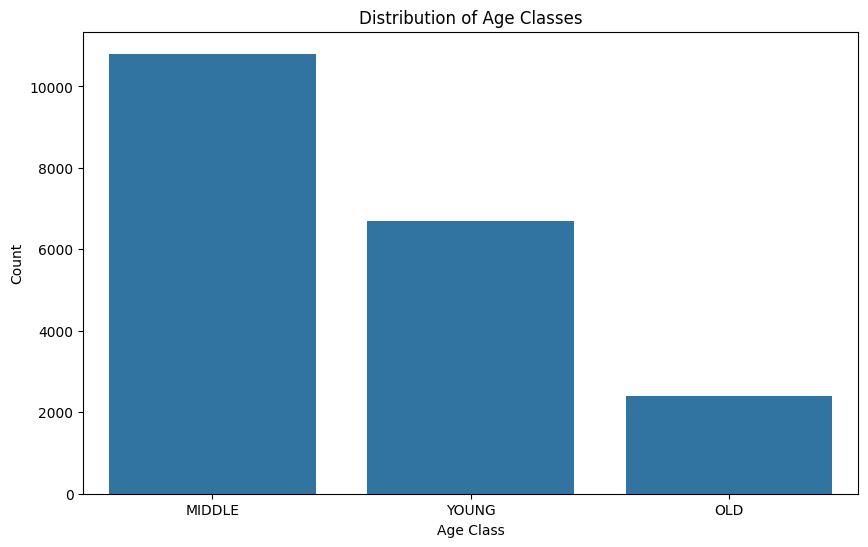

In [23]:
class_distribution = df['Class'].value_counts()
print("\nClass distribution:")
print(class_distribution)

# Vizualizácia distribúcie
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Distribution of Age Classes')
plt.ylabel('Count')
plt.xlabel('Age Class')
plt.show()

#### Analýza obrazkov

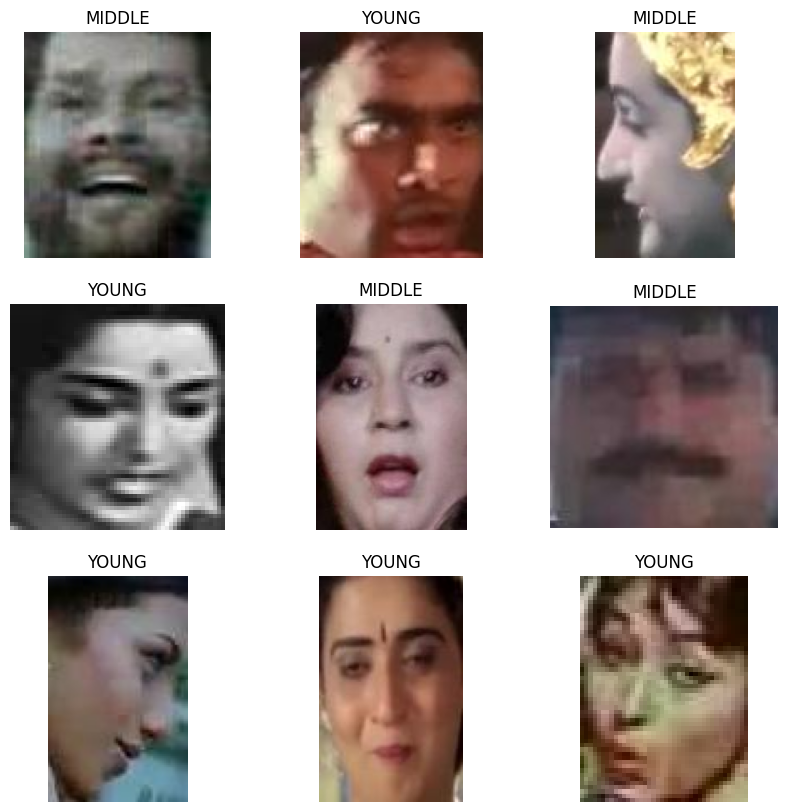

In [24]:
# Zobrazenie niekoľkých obrázkov
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join('faces/train', df['ID'][i])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
    plt.title(df['Class'][i])
    plt.axis('off')
plt.show()

#### Ako mozme vidiet, obrazky nie su rovnakej velkosti a nemaju rovnaku kvalitu, tak musime spravit nejaky preproccesing

### Preprocessing

#### V tomto kode
- Štandardizujeme veľkosť všetkých obrázkov
- Normalizujeme hodnoty pixelov do rozsahu 0-1
- Rozdelíme dataset na trénovaciu a validačnú časť
- Vytvoríme efektívny generátor dát pre trénovanie

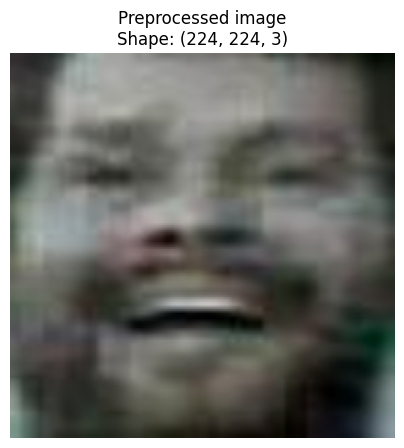

In [27]:
# Definujeme konštanty pre preprocessing
TARGET_SIZE = (224, 224)  # štandardná veľkosť pre mnohé CNN architektúry
BATCH_SIZE = 32

# Enkódovanie labelov
label_encoder = LabelEncoder()
df['Class_encoded'] = label_encoder.fit_transform(df['Class'])

# Vytvorenie funkcie na preprocessing obrázkov
def preprocess_image(image_path, target_size=TARGET_SIZE):
    img_path = os.path.join('faces/train', image_path)
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    # Konverzia z BGR do RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize na štandardnú veľkosť
    img = cv2.resize(img, target_size)
    
    # Normalizácia hodnôt na rozsah 0-1
    img = img / 255.0
    
    return img

# Testovanie preprocessing funkcie na jednom obrázku
sample_img = preprocess_image(df['ID'].iloc[0])
if sample_img is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(sample_img)
    plt.title(f"Preprocessed image\nShape: {sample_img.shape}")
    plt.axis('off')
    plt.show()

In [28]:
# Rozdelenie datasetu na trénovaciu a validačnú časť
train_df, val_df = train_test_split(df, 
                                   test_size=0.2, 
                                   stratify=df['Class'], 
                                   random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 15924
Validation set size: 3982


Batch shape: (32, 224, 224, 3)
Labels shape: (32,)


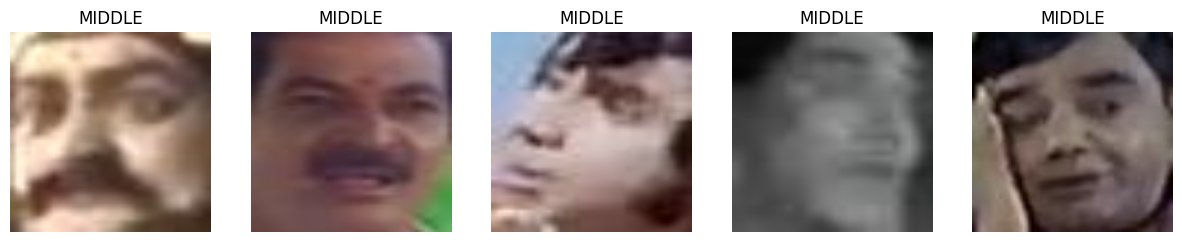

In [ ]:
# Vytvorenie data generátora pre efektívne načítanie dát
class ImageDataGenerator:
    def __init__(self, dataframe, batch_size=BATCH_SIZE, is_training=True):
        self.df = dataframe
        self.batch_size = batch_size
        self.is_training = is_training
        
    def __len__(self):
        return len(self.df) // self.batch_size
    
    def generate_batch(self):
        while True:
            indices = np.random.permutation(len(self.df))
            for start in range(0, len(indices), self.batch_size):
                batch_indices = indices[start:start + self.batch_size]
                batch_df = self.df.iloc[batch_indices]
                
                batch_images = []
                batch_labels = []
                
                for _, row in batch_df.iterrows():
                    img = preprocess_image(row['ID'])
                    if img is not None:
                        batch_images.append(img)
                        batch_labels.append(row['Class_encoded'])
                
                if batch_images:  # ak máme aspoň jeden platný obrázok
                    yield np.array(batch_images), np.array(batch_labels)

# Vytvorenie generátorov pre tréning a validáciu
train_generator = ImageDataGenerator(train_df)
val_generator = ImageDataGenerator(val_df, is_training=False)

# Test generátora - zobrazenie jednej dávky
test_batch_images, test_batch_labels = next(train_generator.generate_batch())
print("Batch shape:", test_batch_images.shape)
print("Labels shape:", test_batch_labels.shape)

# Zobrazenie niekoľkých preprocessovaných obrázkov z dávky
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_batch_images[i])
    plt.title(label_encoder.inverse_transform([test_batch_labels[i]])[0])
    plt.axis('off')
plt.show()

## 4.1.B

### Pre Age Detection dataset by som navrhol použiť Konvolučnú neurónovú sieť (CNN), konkrétne architektúru založenú na ResNet50. Tu je zdôvodnenie výberu:

#### Charakter dát:

- Pracujeme s obrázkami tvárí
- Máme 3 triedy (YOUNG, MIDDLE, OLD)
- Dataset obsahuje veľké množstvo vzoriek (26541 obrázkov)
- Obrázky majú rôznu kvalitu a veľkosť


#### Prečo CNN?

- CNN sú špecializované na spracovanie obrazových dát
- Automaticky sa učia hierarchiu príznakov - od jednoduchých hrán až po komplexné vzory
- Dokážu si poradiť s variabilitou v pozícii a veľkosti príznakov
- Sú robustné voči menším zmenám v obrázkoch


#### Prečo konkrétne ResNet50:

- Hlboká architektúra umožňuje zachytiť komplexné vzory starnutia
- Residuálne spojenia pomáhajú s problémom miznúceho gradientu
- Je predtrénovaná na ImageNet, čo umožňuje transfer learning
- Dokázala svoju efektivitu v podobných úlohách klasifikácie tvárí


#### Alternatívy, ktoré boli zvážené:

- VGG16/19: Jednoduchšia architektúra, ale náchylnejšia na preučenie
- MobileNet: Ľahšia architektúra, ale môže byť nedostatočne komplexná
- Custom CNN: Potrebovala by dlhší čas na tréning a ladenie